In [27]:
import torch
import torch.nn.functional as F

from PIL import Image

import os
import json
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import pandas as pd

import torchvision
from torchvision import models
from torchvision import transforms

from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz
from captum.attr import FeatureAblation

%matplotlib inline

In [2]:
model = torch.load('weights/classifier.pth')
model.eval()
torch.manual_seed(123)
np.random.seed(123)

In [29]:
df = pd.read_csv('data/train.csv')

df['image'] = df['Image_Label'].apply(lambda x: x.split('_')[0])
df[df['image'] == '0a1b596.jpg']

,Image_Label,EncodedPixels,image
820,0a1b596.jpg_Fish,NaN,0a1b596.jpg
821,0a1b596.jpg_Flower,NaN,0a1b596.jpg
822,0a1b596.jpg_Gravel,528792 399 530192 399 531592 399 532992 399 53...,0a1b596.jpg
823,0a1b596.jpg_Sugar,1022510 319 1023910 319 1025310 319 1026710 31...,0a1b596.jpg


In [3]:
transform = transforms.Compose([
 transforms.Resize(256),
 transforms.CenterCrop(224),
 transforms.ToTensor()
])

transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

img = Image.open('data/train_images/0a1b596.jpg')
transformed_img = transform(img)

input = transform_normalize(transformed_img)
input = input.unsqueeze(0).to('cuda:0')
output = model(input)

In [4]:
idx_to_labels = ['flower', 'gravel', 'sugar', 'fish']

output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)

pred_label_idx.squeeze_()

predicted_label = idx_to_labels[pred_label_idx.item()]
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

Predicted: sugar ( 0.30858540534973145 )


Predicted: sugar ( 0.30858540534973145 )


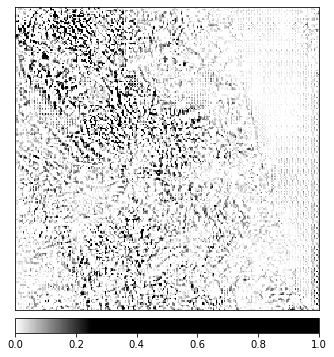

In [20]:
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

integrated_gradients = IntegratedGradients(model)
attributions_ig = integrated_gradients.attribute(input, target=pred_label_idx, n_steps=5)
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

feature_map = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)

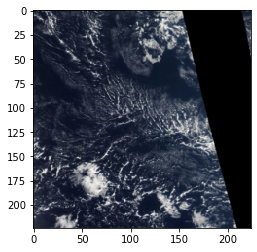

In [24]:
imshow(transformed_img.detach().cpu().numpy().transpose((1, 2, 0)))

In [25]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(input,
                                       strides = (3, 8, 8),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3,15, 15),
                                       baselines=0)

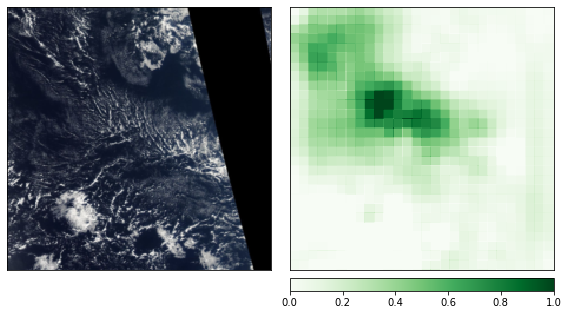

In [26]:
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )